In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import shutil
import os
from collections import *
from PIL import Image,ImageOps
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pywt

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
import scipy
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sn

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y 
y
  Successfully uninstalled tensorflow-2.3.0


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


In [ ]:
#train data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data 
#test data
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P data
! unzip data/GTSRB_Final_Test_Images.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/GTSRB/Final_Test/Images/07632.ppm  
  inflating: data/GTSRB/Final_Test/Images/07633.ppm  
  inflating: data/GTSRB/Final_Test/Images/07634.ppm  
  inflating: data/GTSRB/Final_Test/Images/07635.ppm  
  inflating: data/GTSRB/Final_Test/Images/07636.ppm  
  inflating: data/GTSRB/Final_Test/Images/07637.ppm  
  inflating: data/GTSRB/Final_Test/Images/07638.ppm  
  inflating: data/GTSRB/Final_Test/Images/07639.ppm  
  inflating: data/GTSRB/Final_Test/Images/07640.ppm  
  inflating: data/GTSRB/Final_Test/Images/07641.ppm  
  inflating: data/GTSRB/Final_Test/Images/07642.ppm  
  inflating: data/GTSRB/Final_Test/Images/07643.ppm  
  inflating: data/GTSRB/Final_Test/Images/07644.ppm  
  inflating: data/GTSRB/Final_Test/Images/07645.ppm  
  inflating: data/GTSRB/Final_Test/Images/07646.ppm  
  inflating: data/GTSRB/Final_Test/Images/07647.ppm  
  inflating: data/GTSRB/Final_Test/Images/07648.ppm  
  inflating: data/GTSRB/Final_T

In [ ]:
datadir= '/content/data/GTSRB/Final_Training/Images'

In [ ]:
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
labels=[]
training_data=[]

In [ ]:
#grayscale wavelet
for c in range(0, 43):
  filename = os.path.join(datadir, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
  newrows = []
  with open(filename) as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)
    for row in reader:
      filename = row[0]
      im = Image.open(os.path.join(datadir, format(c, '05d'), filename))
      img=im.resize((60,60))
      img = ImageOps.grayscale(img)
      coeffs = pywt.dwt2(img, 'haar',mode='periodization')
      ca, (ch, cv, cd) = coeffs
      ca=np.reshape(ca, ca.shape + (1,))
      training_data.append(ca)
      labels.append(c)

In [ ]:
x_train=np.array(training_data)
x_train= x_train/255.0

y_train=np.array(labels)
y_train = to_categorical(y_train, num_classes)

In [ ]:
x_train = np.array(x_train).reshape(-1,30, 30, 1)

In [ ]:
X_train,X_valid,Y_train,Y_valid = train_test_split(x_train,y_train,test_size = 0.3,random_state=0)

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
def model_cnn(input_shape=input_shape, num_classes=num_classes):
  with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def model_cnn2(input_shape=input_shape, num_classes=num_classes):
  with tf.device('/gpu:0'):
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = input_shape, activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
models = []
models.append(model_cnn())
models.append(model_cnn2())

In [ ]:
model = []
for i in range(len(models)):
    epochs = 10
    history = models[i].fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=epochs,verbose=1)
    '''models[i].fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                        epochs = epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                        validation_data = (x_test,y_test), 
                                        callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
                                        verbose=2)'''
    model.append(models[i])

Epoch 1/10
858/858 [==============================] - 5s 5ms/step - loss: 1.6904 - accuracy: 0.5350 - val_loss: 0.1725 - val_accuracy: 0.9547
Epoch 2/10
858/858 [==============================] - 4s 5ms/step - loss: 0.2856 - accuracy: 0.9133 - val_loss: 0.0612 - val_accuracy: 0.9851
Epoch 3/10
858/858 [==============================] - 4s 5ms/step - loss: 0.1570 - accuracy: 0.9514 - val_loss: 0.0394 - val_accuracy: 0.9904
Epoch 4/10
858/858 [==============================] - 4s 5ms/step - loss: 0.1183 - accuracy: 0.9642 - val_loss: 0.0314 - val_accuracy: 0.9919
Epoch 5/10
858/858 [==============================] - 4s 5ms/step - loss: 0.0960 - accuracy: 0.9696 - val_loss: 0.0233 - val_accuracy: 0.9942
Epoch 6/10
858/858 [==============================] - 4s 5ms/step - loss: 0.0764 - accuracy: 0.9753 - val_loss: 0.0218 - val_accuracy: 0.9949
Epoch 7/10
858/858 [==============================] - 4s 5ms/step - loss: 0.0713 - accuracy: 0.9766 - val_loss: 0.0205 - val_accuracy: 0.9949
Epoch 

In [ ]:
#test
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P data
! unzip data/GTSRB_Final_Test_GT.zip -d data/GTSRB/Final_Test/Images/


--2020-11-24 10:40:59--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99620 (97K) [application/zip]
Saving to: ‘data/GTSRB_Final_Test_GT.zip’

GTSRB_Final_Test_GT 100%[===================>]  97.29K   209KB/s    in 0.5s    

2020-11-24 10:41:00 (209 KB/s) - ‘data/GTSRB_Final_Test_GT.zip’ saved [99620/99620]

Archive:  data/GTSRB_Final_Test_GT.zip
  inflating: data/GTSRB/Final_Test/Images/GT-final_test.csv  


In [ ]:
#grayscale wavelet
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
test_labels=[]
test_data=[]
datadir='/content/data/GTSRB/Final_Test/Images'
filename = "/content/data/GTSRB/Final_Test/Images/GT-final_test.csv"
with open(filename) as f:
  reader = csv.reader(f, delimiter=';')
  next(reader)
  for row in reader:
    filename = row[0]
    im = Image.open(os.path.join(datadir, filename))
    img=im.resize((60,60))
    img = ImageOps.grayscale(img)
    coeffs = pywt.dwt2(img, 'haar',mode='periodization')
    ca, (ch, cv, cd) = coeffs
    ca=np.reshape(ca, ca.shape + (1,))
    test_data.append(ca)
    test_labels.append(int(row[7]))

In [ ]:
x_test=np.array(test_data)
x_test= x_test/255.0
y_test=np.array(test_labels)
y_test = to_categorical(y_test, num_classes)
x_test = np.array(x_test).reshape(-1,30, 30, 1)


In [ ]:
for m in model:
    predicts = np.argmax(m.predict(x_test), axis=1) #take max of either of the model
pred = to_categorical(predicts, num_classes)
accuracy_score(y_test,pred)

0.9536025336500396

In [ ]:
cm=confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))

In [ ]:
cm = cm/cm.sum(axis=1)[:,np.newaxis]

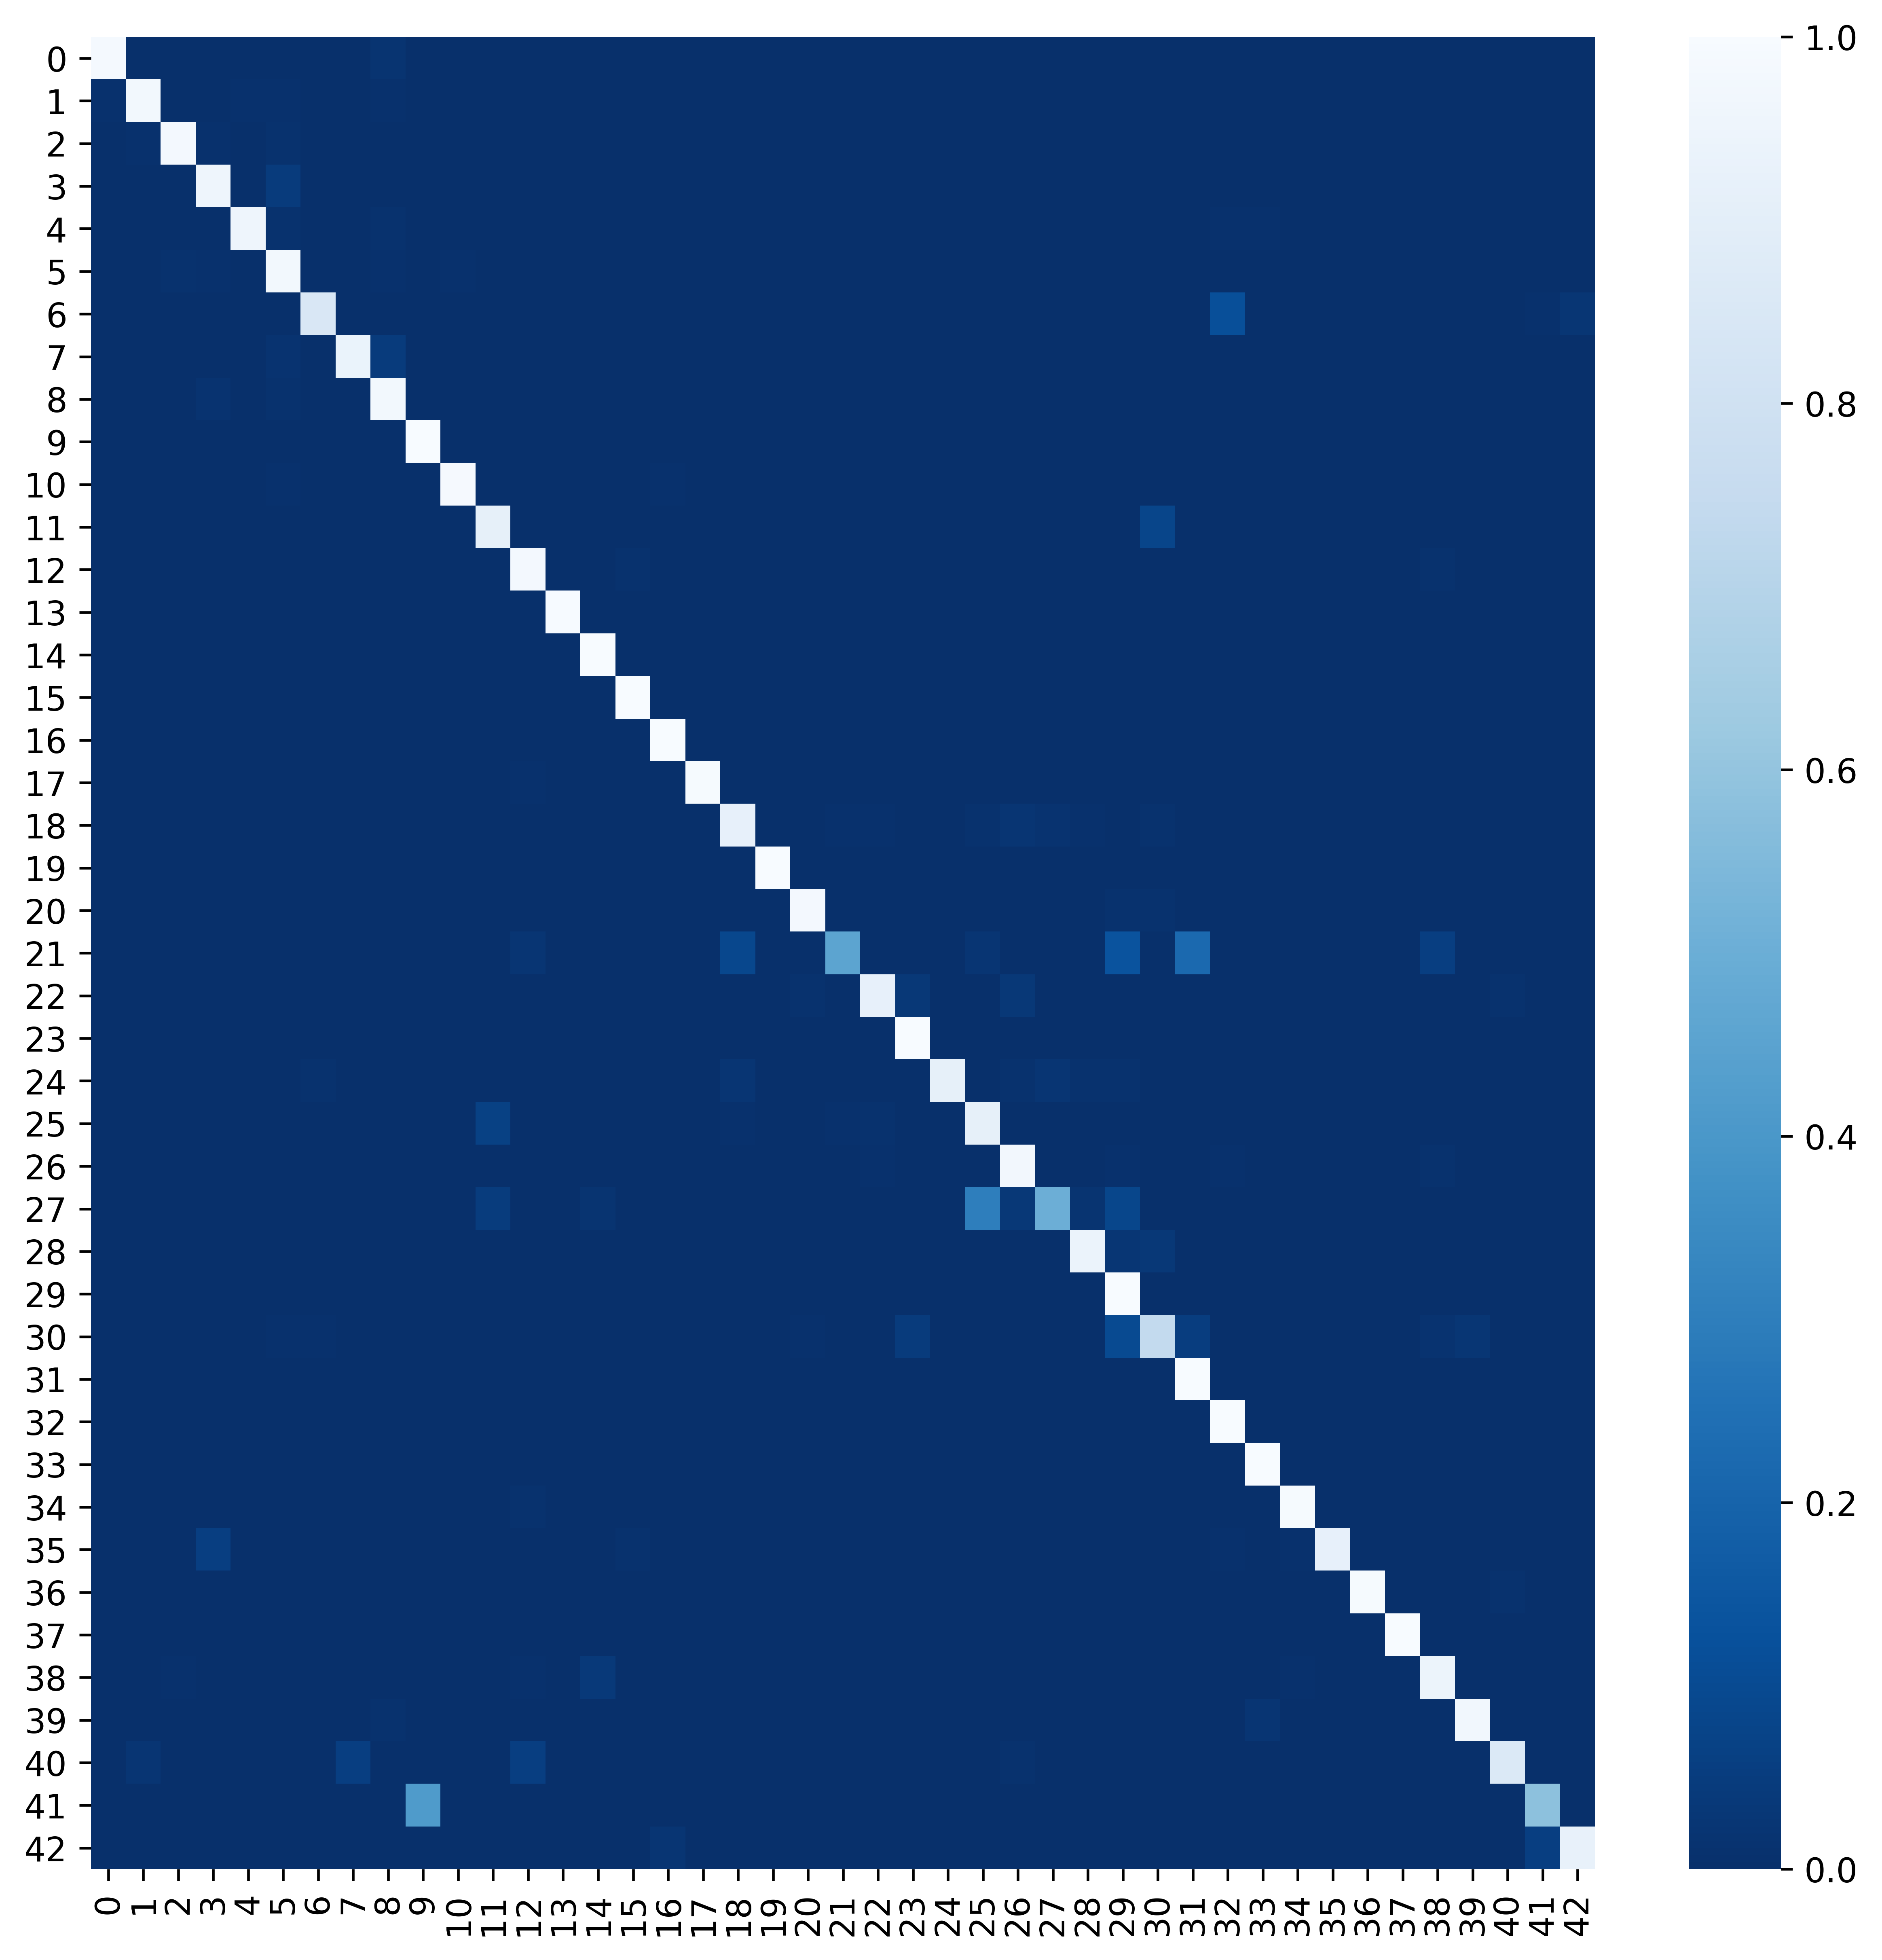

In [ ]:
plt.figure(figsize = (10,10),dpi=600)
sn.heatmap(cm,cmap="Blues_r")


In [ ]:
for m in model:
  m.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)         

In [ ]:
acc=history.history['accuracy']
valacc=history.history['val_accuracy']

In [ ]:
for i in range(0,10):
  acc[i]=acc[i]*100
  valacc[i]=valacc[i]*100

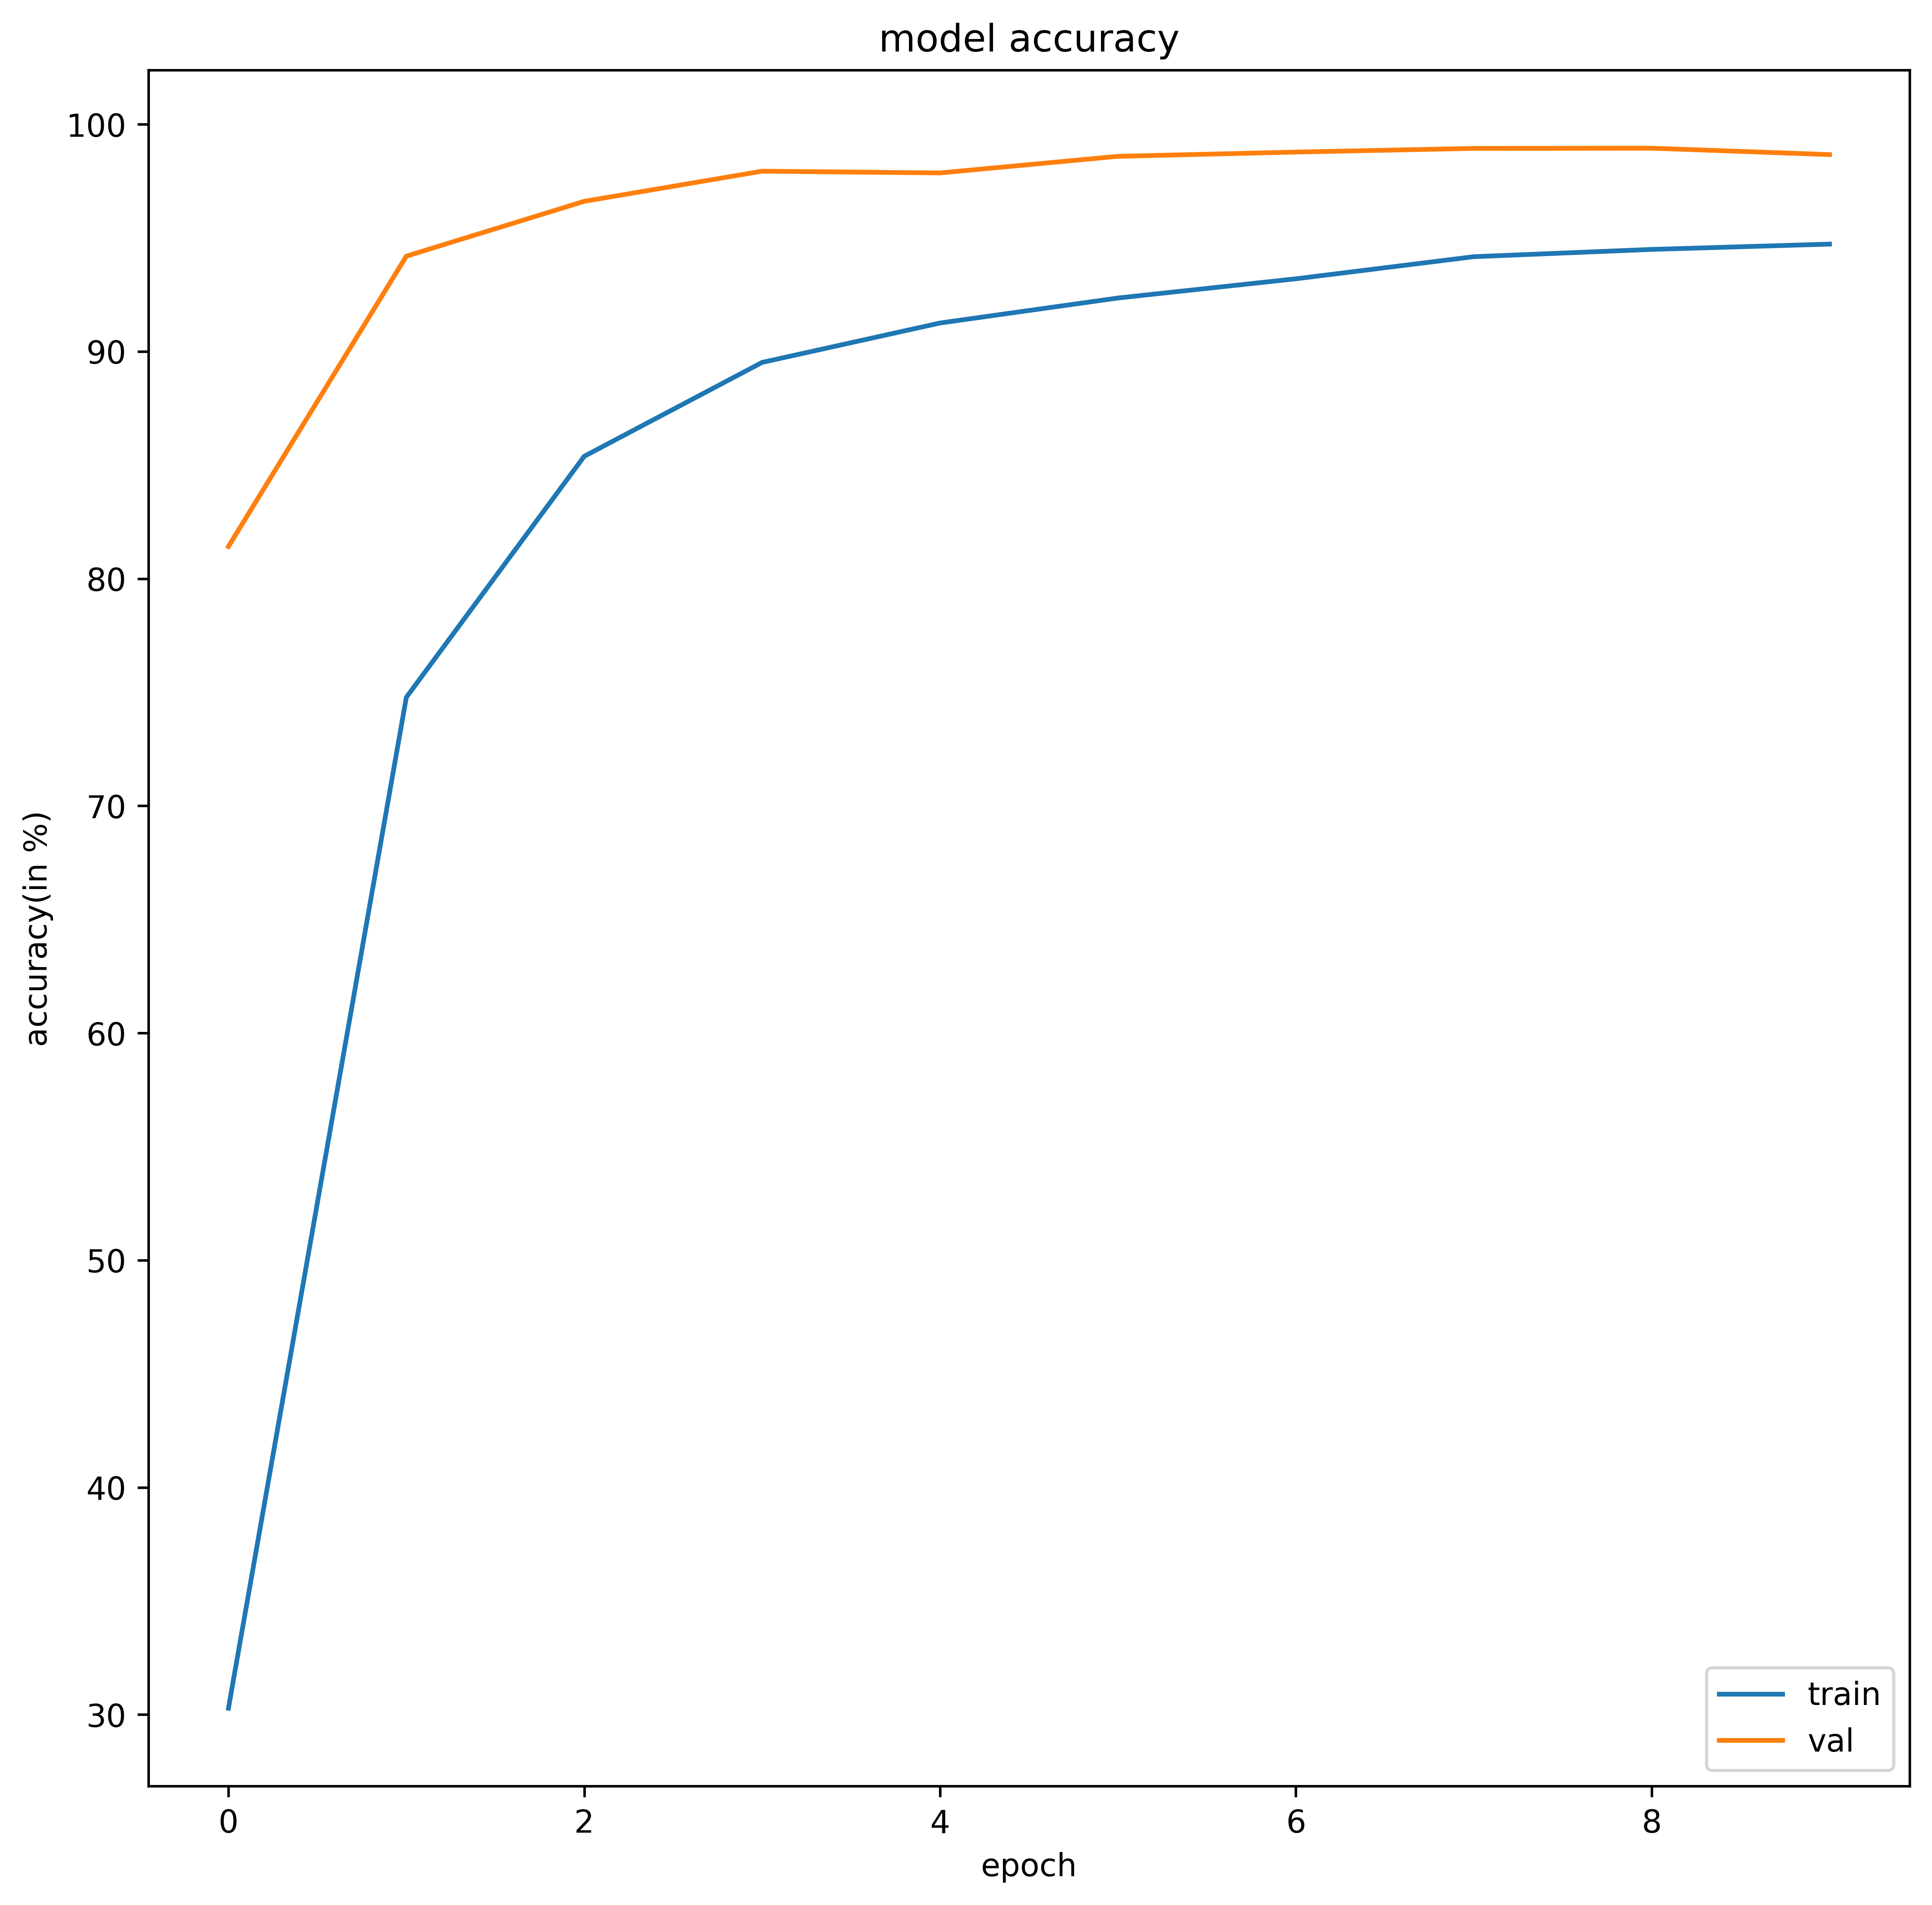

In [ ]:
plt.figure(figsize = (10,10),dpi=600)
plt.plot(acc)
plt.plot(valacc)
plt.title('model accuracy')
plt.ylabel('accuracy(in %)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
loss=[]
valloss=[]
for i in range(0,10):
  loss.append(100 - acc[i])
  valloss.append(100-valacc[i])

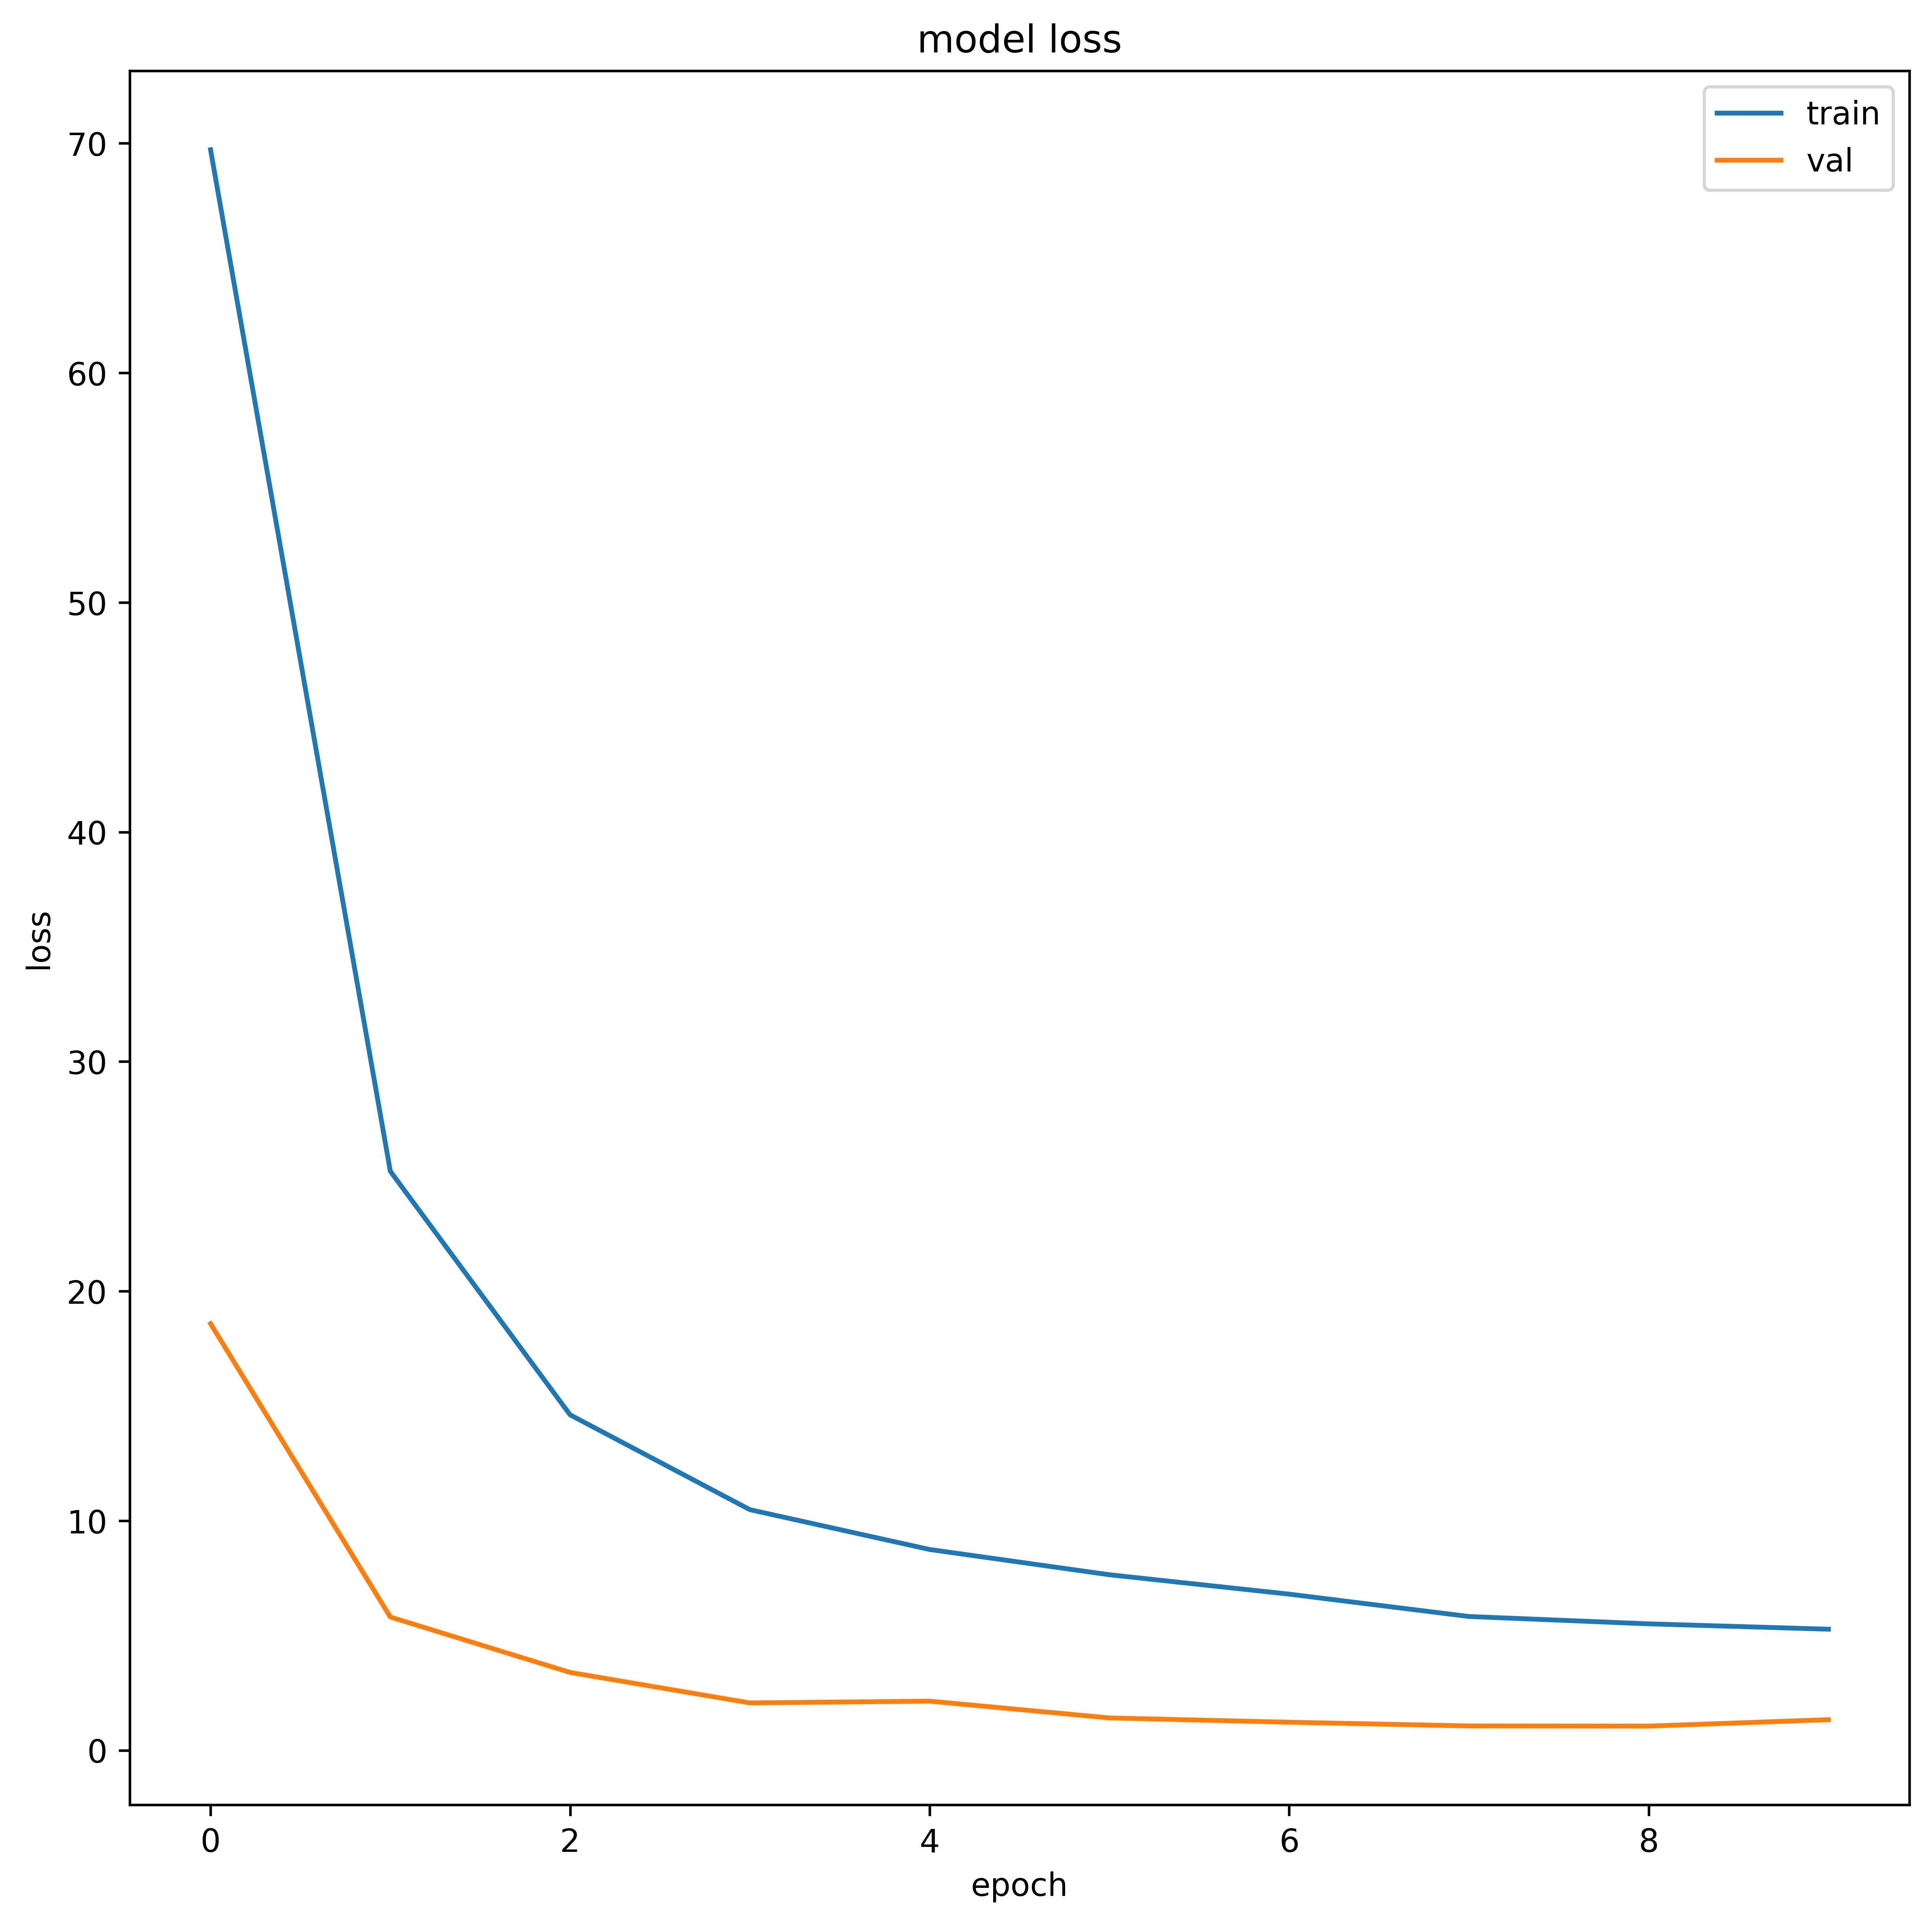

In [ ]:
plt.figure(figsize = (10,10),dpi=600)
plt.plot(loss)
plt.plot(valloss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import precision_score
print("Precision")
precision_score(y_test, pred,average='weighted')


Precision


0.9659013252328061

In [ ]:
from sklearn.metrics import recall_score
print("Recall")
recall_score(y_test, pred,average='weighted')

Recall


0.9676167854315123

In [ ]:
from sklearn.metrics import f1_score
print("F1")
f1_score(y_test, pred,average='weighted')

F1


0.9670753223860492

**Following was for trial for normal grayscale,above is the final result**

In [ ]:
labels = []
for m in model:
    predicts = np.argmax(m.predict(X_valid), axis=1) #take max of either of the model
    labels.append(predicts)

In [ ]:
pred = to_categorical(predicts, num_classes)

In [ ]:
accuracy_score(Y_valid,pred)

0.9930289892034345

In [ ]:
#normal grayscale
datadir= '/content/data/GTSRB/Final_Training/Images'
height = 30
width = 30
channels = 3
num_classes = 43
n_inputs = height * width*channels
labels=[]
training_data=[]
#grayscale 
for c in range(0, 43):
  filename = os.path.join(datadir, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
  newrows = []
  with open(filename) as f:
    reader = csv.reader(f, delimiter=';')
    next(reader)
    for row in reader:
      filename = row[0]
      im = cv2.imread(os.path.join(datadir, format(c, '05d'), filename),cv2.IMREAD_GRAYSCALE)
      image_from_array = Image.fromarray(im, 'L')
      size_image = image_from_array.resize((height, width))
      training_data.append(np.array(size_image))
      labels.append(c)
x_train=np.array(training_data)
x_train= x_train/255.0

y_train=np.array(labels)
y_train = to_categorical(y_train, num_classes)
x_train = np.array(x_train).reshape(-1,30, 30, 1)
X_train,X_valid,Y_train,Y_valid = train_test_split(x_train,y_train,test_size = 0.3,random_state=0)
input_shape = X_train.shape[1:]

In [ ]:
model = []
for i in range(len(models)):
    epochs = 15
    history = models[i].fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=epochs,verbose=1)
    '''models[i].fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                                        epochs = epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                        validation_data = (x_test,y_test), 
                                        callbacks=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)], 
                                        verbose=2)'''
    model.append(models[i])

Epoch 1/15
858/858 [==============================] - 10s 12ms/step - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0146 - val_accuracy: 0.9981
Epoch 2/15
858/858 [==============================] - 9s 11ms/step - loss: 0.0186 - accuracy: 0.9945 - val_loss: 0.0148 - val_accuracy: 0.9980
Epoch 3/15
858/858 [==============================] - 9s 11ms/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.0144 - val_accuracy: 0.9974
Epoch 4/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.0132 - val_accuracy: 0.9978
Epoch 5/15
858/858 [==============================] - 9s 11ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.0161 - val_accuracy: 0.9981
Epoch 6/15
858/858 [==============================] - 9s 10ms/step - loss: 0.0211 - accuracy: 0.9943 - val_loss: 0.0164 - val_accuracy: 0.9969
Epoch 7/15
858/858 [==============================] - 9s 11ms/step - loss: 0.0233 - accuracy: 0.9938 - val_loss: 0.0153 - val_accuracy: 0.997

In [ ]:
for m in model:
    predicts = np.argmax(m.predict(X_valid), axis=1) #take max of either of the model
pred = to_categorical(predicts, num_classes)
accuracy_score(Y_valid,pred)

0.9952393096999065

In [ ]:
 from sklearn.metrics import confusion_matrix

In [ ]:
#confusion_matrix(Y_valid,pred)
cm=confusion_matrix(Y_valid.argmax(axis=1), pred.argmax(axis=1))

In [ ]:
cm = cm/cm.sum(axis=1)[:,np.newaxis]

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

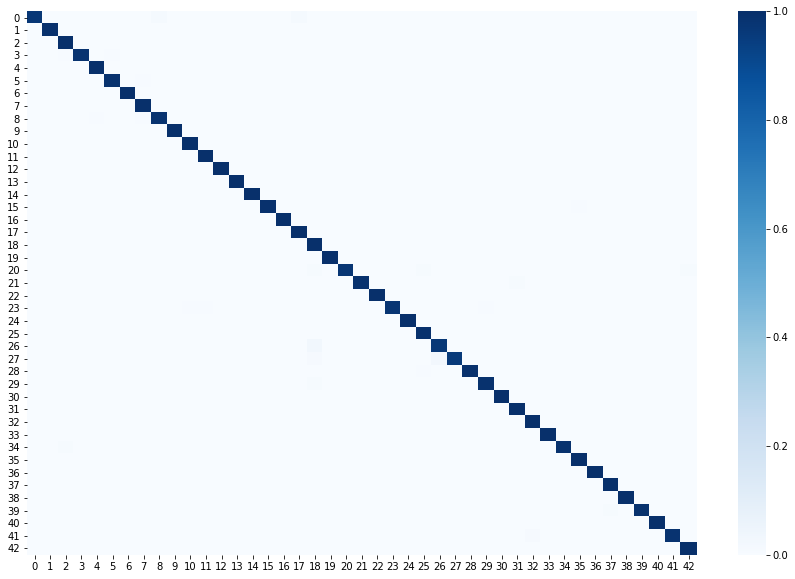

In [ ]:
plt.figure(figsize = (15,10))
sn.heatmap(cm,cmap="Blues")


In [ ]:
!cd data/

In [ ]:
!ls /content/data/GTSRB/Final_Test/Images

In [ ]:
!cat /content/data/GTSRB/Final_Test/Images/GT-final_test.csv